## Linear Regression with TF Probability

Fitting a linear regression to data.

* Linear Regression (I)   The usual probabilistic way (same as standard linear regression)
* Linear Regression (II)  Non-Fixed Variance
* Linear Regression (III) Bayesian Way


See also:
https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf


**This is work in progress. It requires TensorFlow 2.0 and Tensorflow Probability version 0.7**

You can use the following docker container
```
    docker pull oduerr/tf_docker:cpu_r_tfp
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev
TF  Version 2.0.0-alpha0


### Creation of some random data

In [2]:
#@title Synthesize dataset.
num = 200
#x = np.concatenate((np.linspace(-10,-1,num), np.linspace(1,10,num))).reshape(2*num,1)
x = np.linspace(1,10,2*num).reshape(2*num,1)
y = np.random.normal(1*x[:,0]+5,np.abs(x[:,0])/2)
x.shape, y.shape

((400, 1), (400,))

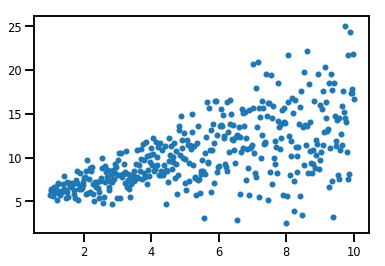

In [3]:
plt.scatter(x,y, marker='.')

### Case 1: No Uncertainty

Here we encounter the first new thing. A `DistributionLambda` layer. Let's take a step back and first consider a general form of the problem. We want to model the probability for an outcome $y$ (regression or class probabilities) given some x-data and weights $w$ as.

$$
    p(y | x, w) 
$$

A way to do this is to have a distribuition, say a Gaussian, with parameters $\mu$ and $\sigma$. Other distributions with parameters, like Poisson, Exponential, Weilbull, etc. are possible. We now let the network choose the parameter, by a maximum likelihood approach (see below for details).

  * $\mu$ is the output of the neural network, controlling the parameters mean of the distribution
  * sd is fixded here for the time being and not learned by the data (below we will learn it) 
  * The output of the network is a probability distribution. Here ${\tt normal}(x; \mu, sd=1)$ 
  

The `DistributionLambda(Prob(parameters))` takes returns a parametrized distribution. We, just have to "hand-in" the distribution we want. 

In our case, we first use a Gaussian with fixed variance. This is the usual linear regression setting.

In [4]:
## Definition of the custom parametrized distribution
def my_gauss(mu):
  return tfd.Normal(loc=mu, scale=1)

## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(1,))
mu = tf.keras.layers.Dense(1)(inputs)
p_y = tfp.layers.DistributionLambda(my_gauss)(mu) #<------- Here we hand-in the the custom distribution

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y) 

In [5]:
x_test = np.linspace(-3,15, num=100).astype(np.float32) #Some x values, where we want to test
x_test = x_test[..., np.newaxis]  #Make a (100,1) Tensor
x_test_1p = x_test[0, np.newaxis] #Just take a single row
y_hat = model(x_test_1p) #The endpoint of the network

# The output is a distribution
# ... we have a mean, can sample and can determine the log-probability for a given value
y_hat, y_hat.sample(), y_hat.mean(), y_hat.log_prob(10),x_test.shape

(<tfp.distributions.Normal 'model/distribution_lambda/Normal/' batch_shape=(1, 1) event_shape=() dtype=float32>,
 <tf.Tensor: id=104, shape=(1, 1), dtype=float32, numpy=array([[-0.14998245]], dtype=float32)>,
 <tf.Tensor: id=109, shape=(1, 1), dtype=float32, numpy=array([[-1.9277297]], dtype=float32)>,
 <tf.Tensor: id=119, shape=(1, 1), dtype=float32, numpy=array([[-72.054306]], dtype=float32)>,
 (100, 1))

#### Training

We train using the usual max-likelihood method. I.e., we maximize the likelihood (w.r.t. the weights) that, given the data, the $y_tue$ is observed. Practically, we minimize the negative log-likelihood.

##### Definition of the likelihood

$$
  l=-\log(p_{\tt model}(y_{\tt true} | X, w))
$$

For more than one data point, we would need to sum. 

**Comment** This is a function, which compares the true label y with the output of the last layer


In [6]:
# The likelihood is simply 
#Short Version: 
#  negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# y_true the true class label 
# y_hat the output probability distribution
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

In [7]:
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

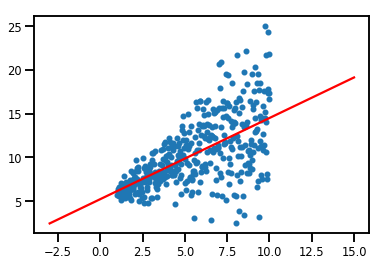

In [8]:
# Visualization of the result
y_hat = model(x_test)
mu = y_hat.mean()
plt.scatter(x,y, marker='.')
plt.plot(x_test,mu, c='r')

### Case 2: Modeling the stddev 

Here we also model the stddev from the neural network. We get an estimate for the (known unkowns) the aleatoric uncertainty. 

#### Modeling the softplus
Note that, instead of modeling the standard-deviatation directly, we use the softplus. Which transforms a number from  [−∞,+∞]  to posive numbers.

Text(0, 0.5, 'softplus')

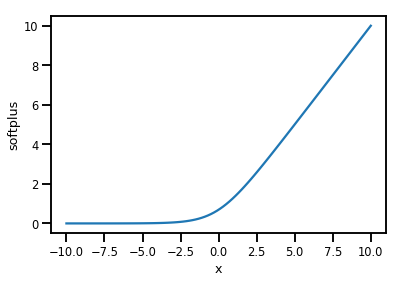

In [9]:
xs = np.linspace(-10,10,100)
sp = tf.math.softplus(xs)
plt.plot(xs,sp)
plt.xlabel('x')
plt.ylabel('softplus')

In [10]:
#Just some notation which might be unkown
dd = np.random.normal(size=(3,2))
dd[...,:1] #Keeps the shape intact

array([[ 0.07764792],
       [-0.69068113],
       [ 1.61483339]])

In [11]:
def my_gauss2(t):
  mu = t[...,:1] #First column mu
  scale = 1e-3 + tf.math.softplus(0.05 * t[...,1:]) #Second column sigma
  return tfd.Normal(loc=mu, scale=scale)

#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(1,))
t = tf.keras.layers.Dense(2)(inputs) #<-- 2 outputs
p_y = tfp.layers.DistributionLambda(my_gauss2)(t)
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)


model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

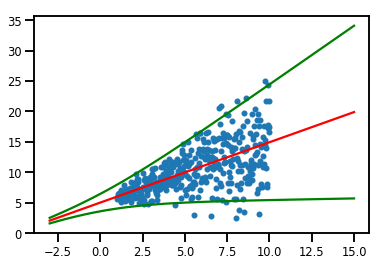

In [12]:
y_hat = model(x_test)
mu = y_hat.mean()
sig = y_hat.stddev()
plt.scatter(x,y, marker='.')
plt.plot(x_test,mu, c='r')
plt.plot(x_test,mu + 2*sig, c='g')
plt.plot(x_test,mu - 2*sig, c='g')

### Case 3: Epistemic Uncertainty (Specifying the uncertainties by hand)

To model the uncertainty which arises, due to the lack of data, we start a Bayesian treatment.

#### Definition of the posterior
For the posterior $𝑄(𝑤;\theta)$, we use a Gaussian approximation. For each weights and biases (n in total) a Gaussian Distribution is learned. We assume independence between the distributions for the weights and thus have 2*n parameters for $\theta$. 

In [13]:
# In more easy code
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size #Number of weights
  c = np.log(np.expm1(1.)) #Magic number for offsetting in softpuls
  
  model = tf.keras.Sequential()
  # Creating 2n variables as a starting point
  variables = tfp.layers.VariableLayer(2 * n, dtype=dtype, name='post_weights')
  model.add(variables)
  model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Independent(tfd.Normal(
          loc=t[..., :n],scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
                                reinterpreted_batch_ndims=1))
      )
  return (model)


#### Definition of the prior
We also make the prior $P(W;\theta)$ trainable. We assume that it has a Gaussian-Form with fixed stddev=1 but with a trainable mu. This is called empirical Bayes.

In [14]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size

  model = tf.keras.Sequential()
  # Creating n variables as a starting point (we only learn mu)
  variables = tfp.layers.VariableLayer(n, dtype=dtype)
  model.add(variables)
  model.add(tfp.layers.DistributionLambda(lambda t: tfd.Independent(
           tfd.Normal(loc=t, scale=1),
           reinterpreted_batch_ndims=1)))
  return (model)

In [15]:
# Build model.
inputs = tf.keras.layers.Input(shape=(1,))

# Simple linear regression
tt = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(inputs)

## Uncomment to make a NN 
#tt = tfp.layers.DenseVariational(5, posterior_mean_field, prior_trainable, activation='sigmoid')(inputs)
#tt = tfp.layers.DenseVariational(5, posterior_mean_field, prior_trainable, activation='sigmoid')(tt)
#tt = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable)(tt)

p_y = tfp.layers.DistributionLambda(my_gauss)(tt)
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

#### Sampling from the posterior

The weights of the network, follow a distribution. We can sample from the posterior by calling
```
    p = model(x_test)
    # Note that p is a distribution, with mean and std,...
    p.mean() #Sample the mean from it
```

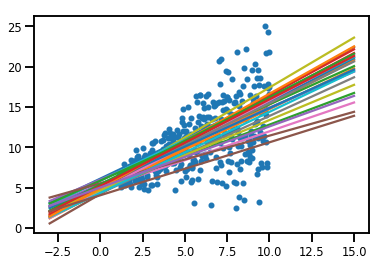

In [16]:
plt.scatter(x,y, marker='.')
plt.plot(x_test,model(x_test).mean())
for _ in range(25):
    plt.plot(x_test,model(x_test).mean(),ls='-')

#### Averagring

Now, we average over many runs of the network. This is the same as taking the mean of the predictive distribution. 

In [17]:
mus = np.zeros(shape=(50,100))
for i in range(0,50):
    y_hat = model(x_test)
    mu = y_hat.mean()
    mus[i] = mu[:,0]

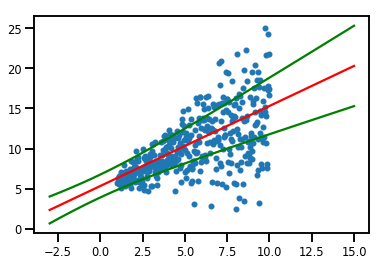

In [18]:
plt.scatter(x,y, marker='.')
m = np.mean(mus,axis=0)
s = np.std(mus, axis=0)
plt.plot(x_test,m, c='r')
plt.plot(x_test,m + 2*s, c='g')
plt.plot(x_test,m - 2*s, c='g')